In [ ]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
X = np.load('features_q1.npy')
y = np.load('labels_q1.npy')
y_noisy = np.load('noisy_labels_q1.npy')

(1000,)
(1000,)
(1000,)


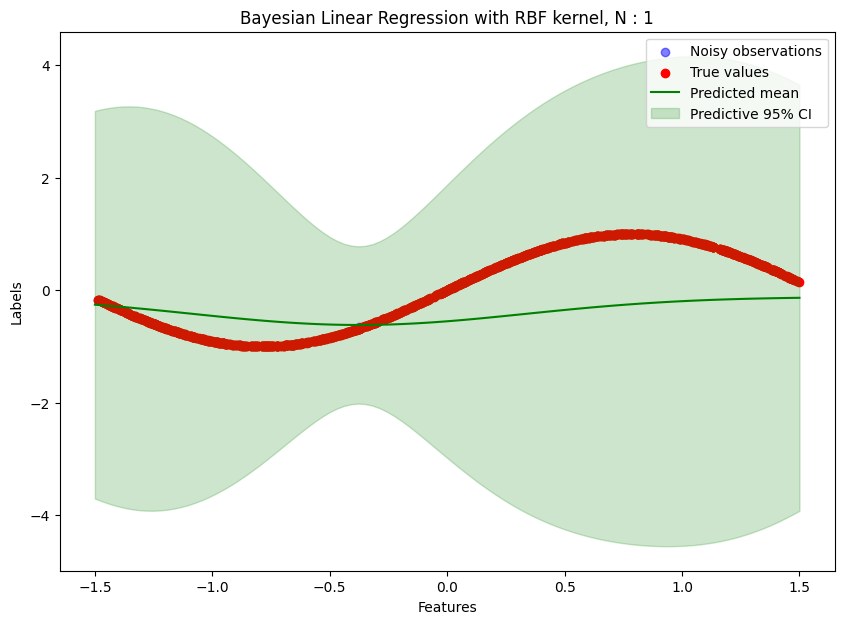

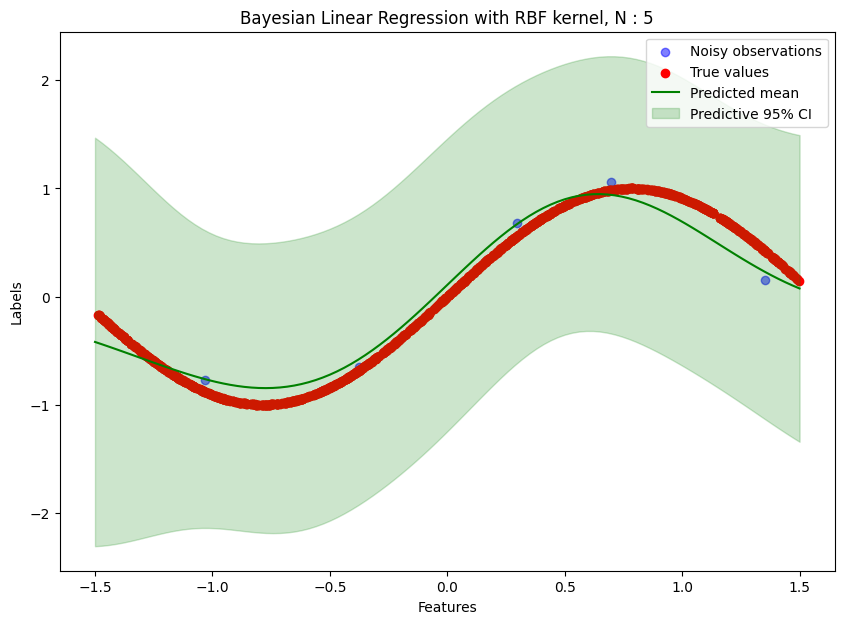

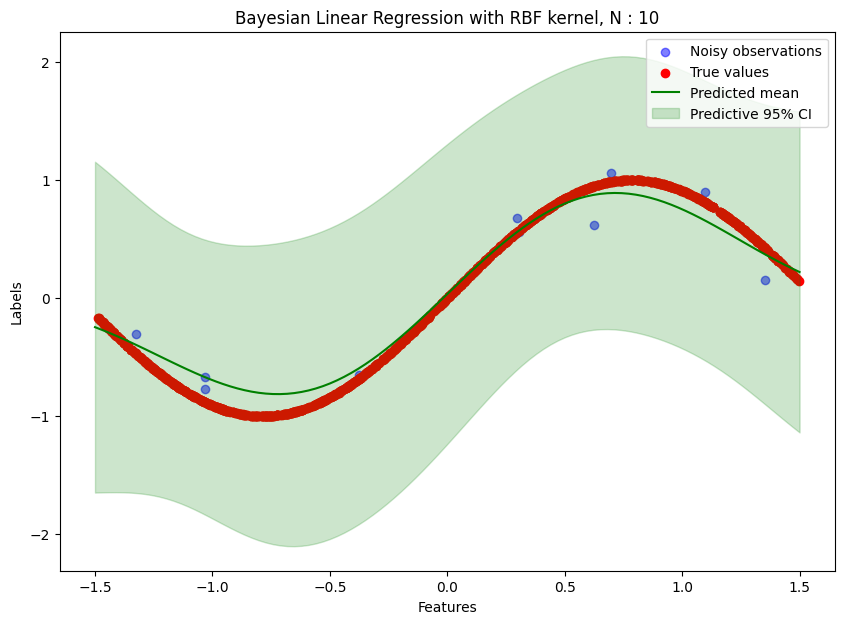

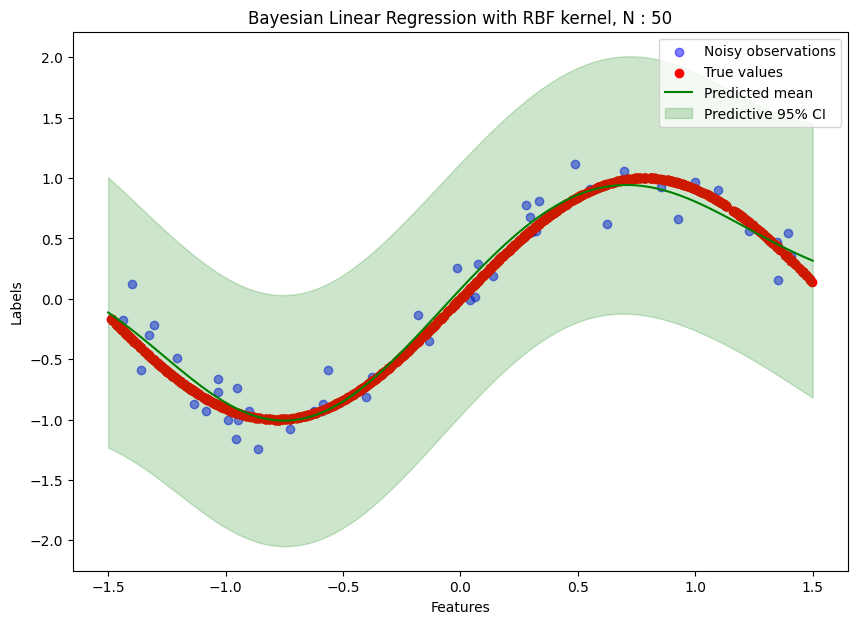

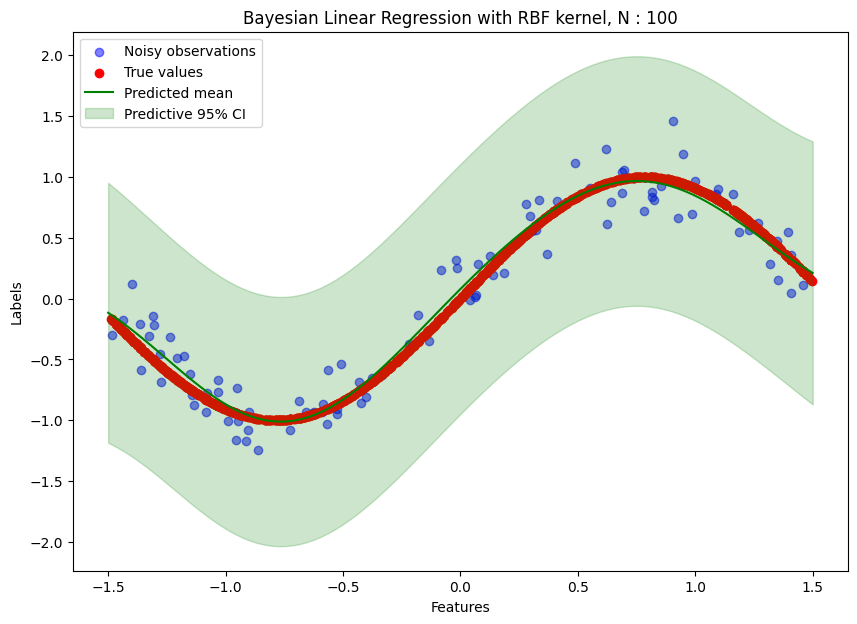

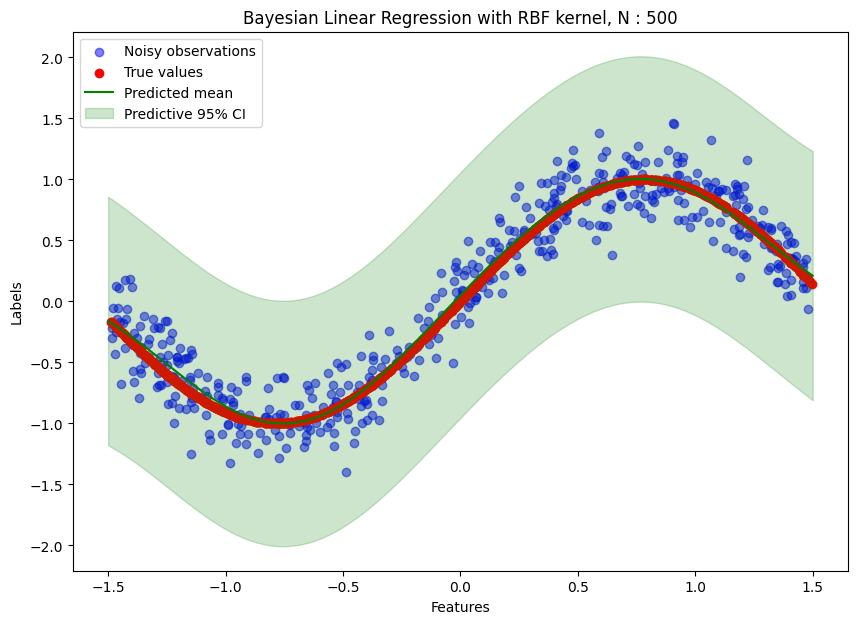

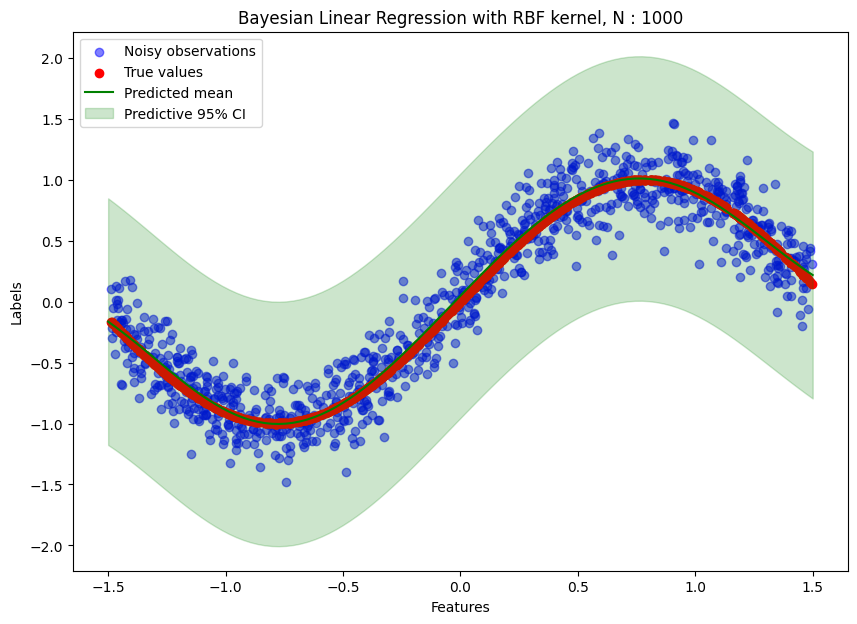

In [ ]:
class BayesianLinearRegressionRBF:
    """ Bayesian linear regression with RBF kernel

    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
        rbf_centers: Centers of the RBF kernels
        rbf_length_scale: Length scale (standard deviation) of the RBF kernels
    """

    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float, rbf_centers: np.ndarray, rbf_length_scale: float):
        # Initialize prior mean and covariance
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        self.prior = multivariate_normal(mean=self.prior_mean, cov=self.prior_cov)
        self.noise_var = noise_var
        self.rbf_centers = rbf_centers
        self.rbf_length_scale = rbf_length_scale
        self.post_mean = self.prior_mean  # corresponds to m_N in formulae
        self.post_cov = self.prior_cov  # corresponds to S_N in formulae
        self.param_posterior = self.prior

    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets

        Args:
            features: numpy array of features
            targets: numpy array of targets
        """
        design_matrix = self.compute_design_matrix(features)
        S0_inv = np.linalg.inv(self.prior_cov)
        SN_inv = S0_inv + (1 / self.noise_var) * design_matrix.T @ design_matrix
        self.post_cov = np.linalg.inv(SN_inv)
        self.post_mean = self.post_cov @ (S0_inv @ self.prior_mean + (1 / self.noise_var) * design_matrix.T @ targets)
        self.param_posterior = multivariate_normal(mean=self.post_mean, cov=self.post_cov)

    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix using RBF kernel features.

        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
        """
        rbf_features = np.exp(-0.5 * ((features[:, None] - self.rbf_centers[None, :]) ** 2) / self.rbf_length_scale ** 2)
        design_matrix = np.hstack([np.ones((features.shape[0], 1)), rbf_features])
        return design_matrix

    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint

        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        design_matrix = self.compute_design_matrix(features)
        pred_mean = design_matrix @ self.post_mean
        pred_cov = design_matrix @ self.post_cov @ design_matrix.T + self.noise_var * np.eye(design_matrix.shape[0])
        pred_posterior = univariate_normal(loc=pred_mean, scale=np.sqrt(np.diag(pred_cov)))
        return pred_posterior

    @staticmethod
    def visualize(X, y, X_sampled, y_noisy, X_test, pred_posterior, n):
        plt.figure(figsize=(10, 7))
        plt.scatter(X_sampled, y_noisy, label="Noisy observations", color='blue', alpha=0.5)
        plt.scatter(X, y, color='r', label="True values")
        plt.plot(X_test, pred_posterior.mean(), label="Predicted mean", color='green')
        plt.fill_between(X_test,
                         pred_posterior.mean() - 2 * pred_posterior.std(),
                         pred_posterior.mean() + 2 * pred_posterior.std(),
                         color='green', alpha=0.2, label="Predictive 95% CI")
        plt.xlabel("Features")
        plt.ylabel("Labels")
        plt.title(f"Bayesian Linear Regression with RBF kernel, N : {n}")
        plt.legend()
        plt.show()

# Random Seed for reproducibility : DO NOT CHANGE
seed = 42
np.random.seed(seed)

# Define RBF Centers and Length Scale
rbf_centers = np.linspace(-1.5, 1.5, 15)
rbf_length_scale = 0.5

# Setup Bayesian Linear Regression with RBF kernel
prior_mean = np.zeros(len(rbf_centers) + 1)
prior_cov = np.eye(len(rbf_centers) + 1) * 1.0
noise_var = 0.5 ** 2

# Example usage (students will fill in these sections for evaluation)
print(X.shape)
print(y.shape)
print(y_noisy.shape)

# Fit the Model & Visualization of the Results
n_train_samples = [1, 5, 10, 50, 100, 500, 1000]
final_result = {
    'X': [],
    'y': [],
    'y_stddev': []
}
for n in n_train_samples:
    model = BayesianLinearRegressionRBF(prior_mean, prior_cov, noise_var, rbf_centers, rbf_length_scale)
    X_test = np.linspace(-1.5, 1.5, 100)
    X_sampled = X[:n]
    y_sampled = y[:n]
    y_noisy_sampled = y_noisy[:n]
    model.update_posterior(X_sampled, y_noisy_sampled)
    pred_posterior = model.predict(X_test)
    if n == 1000:
        final_result['X'] = X_test
        final_result['y'] = pred_posterior.mean()
        final_result['y_stddev'] = pred_posterior.std()
        df = pd.DataFrame(final_result)
        df.to_csv('output.csv', index=False)
    BayesianLinearRegressionRBF.visualize(X, y, X_sampled, y_noisy_sampled, X_test, pred_posterior, n)
